In [2]:
######################################################################
# Computing Communities in Large Networks Using Random Walks
# L42: Assessment 1
# Jan Ondras (jo356), Trinity College
######################################################################
# Walktrap algorithm
######################################################################

import numpy as np
import networkx as nx
from heapq import heappush, heappop
from matplotlib import pyplot as plt
import copy
import time

# Return set of partitions and communities for graph G after t steps of random walk
def walktrap(G, t, add_self_edges=True, verbose=False):

    ##################################################################
    class Community:
        def __init__(self, new_C_id, C1=None, C2=None):
            self.id = new_C_id
            # New community from single vertex
            if C1 == None:
                self.size = 1
                self.P_c = P_t[self.id] # probab vector
                self.adj_coms = {}
                self.vertices = set([self.id])
                self.internal_weight = 0. 
                self.total_weight = self.internal_weight + (len([id for id, x in enumerate(A[self.id]) if x == 1. and id != self.id])/2.) #External edges have 0.5 weight, ignore edge to itself
            # New community by merging 2 older ones
            else:
                self.size = C1.size + C2.size
                self.P_c = (C1.size * C1.P_c + C2.size * C2.P_c) / self.size
                # Merge info about adjacent communities, but remove C1, C2
                self.adj_coms = dict(C1.adj_coms.items() + C2.adj_coms.items())
                del self.adj_coms[C1.id]
                del self.adj_coms[C2.id]
                self.vertices = C1.vertices.union(C2.vertices)
                weight_between_C1C2 = 0.
                for v1 in C1.vertices:
                    for id, x in enumerate(A[v1]):
                        if x == 1. and id in C2.vertices:
                            weight_between_C1C2 += 1.
                self.internal_weight = C1.internal_weight + C2.internal_weight + weight_between_C1C2
                self.total_weight = C1.total_weight + C2.total_weight

        def modularity(self):
            return ( self.internal_weight - (self.total_weight*self.total_weight/G_total_weight) ) / G_total_weight
    ##################################################################
    
    # If needed, add self-edges
    if add_self_edges:
        for v in G.nodes:
            G.add_edge(v, v)
    
    #G = nx.convert_node_labels_to_integers(G) # ensure that nodes are represented by integers starting from 0
    N = G.number_of_nodes()
    
    # Build adjacency matrix A
    A = np.array(nx.to_numpy_matrix(G))

    # Build transition matrix P from adjacency matrix
    # and diagonal degree matrix Dx of negative square roots degrees 
    Dx = np.zeros((N,N))
    P = np.zeros((N,N))
    for i, A_row in enumerate(A):
        d_i = np.sum(A_row)
        P[i] = A_row / d_i
        Dx[i,i] = d_i ** (-0.5)

    # Take t steps of random walk
    P_t = np.linalg.matrix_power(P, t)

    # Weight of all the edges excluding self-edges
    G_total_weight = G.number_of_edges() - N

    # Total number of all communities created so far
    community_count = N
    # Dictionary of all communities created so far, indexed by comID
    communities = {}
    for C_id in range(N):
        communities[C_id] = Community(C_id)

    # Minheap to store delta sigmas between communitites: <deltaSigma(C1,C2), C1_id, C2_id>
    min_sigma_heap = []
    for e in G.edges:
        C1_id = e[0]
        C2_id = e[1]
        if C1_id != C2_id:
            # Apply Definition 1 and Theorem 3
            ds = (0.5/N) * np.sum(np.square( np.matmul(Dx,P_t[C1_id]) - np.matmul(Dx,P_t[C2_id]) ))
            heappush(min_sigma_heap, (ds, C1_id, C2_id))
            # Update each community with its adjacent communites
            communities[C1_id].adj_coms[C2_id] = ds
            communities[C2_id].adj_coms[C1_id] = ds  

    # Record delta sigmas of partitions merged at each step
    delta_sigmas = []
    # Store IDs of current communities for each k
    # Partitions is a list of length k that stores IDs of communities for each partitioning
    partitions = [] # at every step active communities are in the last entry of 'partitions'
    # Make first partition, single-vertex communities
    partitions.append(set(np.arange(N)))
    # Calculate modularity Q for this partition
    modularities = [np.sum([communities[C_id].modularity() for C_id in partitions[0]])]
    if verbose:
        print "Partition 0: ", partitions[0]
        print "Q(0) = ", modularities[0]

    for k in range(1, N):
        # Current partition: partitions[k-1]
        # New partition to be created in this iteration: partitions[k]

        # Choose communities C1, C2 to merge, according to minimum delta sigma
        # Need to also check if C1_id and C2_id are communities at the current partition partitions[k-1]
        while not not min_sigma_heap:
            delta_sigma_C1C2, C1_id, C2_id = heappop(min_sigma_heap)
            if C1_id in partitions[k-1] and C2_id in partitions[k-1]:
                break
        # Record delta sigma at this step
        delta_sigmas.append(delta_sigma_C1C2)

        # Merge C1, C2 into C3, assign to it next possible ID, that is C3_ID = totComCnt
        C3_id = community_count
        community_count += 1 # increase for the next one
        communities[C3_id] = Community(C3_id, communities[C1_id], communities[C2_id])

        # Add new partition (k-th)
        partitions.append(copy.deepcopy(partitions[k-1]))
        partitions[k].add(C3_id) # add C3_ID
        partitions[k].remove(C1_id)
        partitions[k].remove(C2_id)

        # Update delta_sigma_heap with entries concerning community C3 and communities adjacent to C1, C2
        # Check all new neighbours of community C3
        for C_id in communities[C3_id].adj_coms.keys():
            # If C is neighbour of both C1 and C2 then we can apply Theorem 4
            if (C_id in communities[C1_id].adj_coms) and (C_id in communities[C2_id].adj_coms):
                delta_sigma_C1C = communities[C1_id].adj_coms[C_id]
                delta_sigma_C2C = communities[C2_id].adj_coms[C_id]
                # Apply Theorem 4 to (C, C3)
                ds = ( (communities[C1_id].size + communities[C_id].size)*delta_sigma_C1C + (communities[C2_id].size + communities[C_id].size)*delta_sigma_C2C - communities[C_id].size*delta_sigma_C1C2 ) / (communities[C3_id].size + communities[C_id].size)

            # Otherwise apply Theorem 3 to (C, C3)
            else:
                ds = np.sum(np.square( np.matmul(Dx,communities[C_id].P_c) - np.matmul(Dx,communities[C3_id].P_c) )) * communities[C_id].size*communities[C3_id].size / ((communities[C_id].size + communities[C3_id].size) * N)

            # Update min_sigma_heap and update delta sigmas between C3 and C
            heappush(min_sigma_heap, (ds ,C3_id , C_id))
            communities[C3_id].adj_coms[C_id] = ds
            communities[C_id].adj_coms[C3_id] = ds  

        # Calculate and store modularity Q for this partition
        modularities.append(np.sum([communities[C_id].modularity() for C_id in partitions[k]]))
            
        if verbose:
            print "Partition ", k, ": ", partitions[k]
            print "\tMerging ", C1_id, " + ", C2_id, " --> ", C3_id
            print "\tQ(", k, ") = ", modularities[k]
            print "\tdelta_sigma = ", delta_sigmas[k-1]

    return np.array(partitions), communities, np.array(delta_sigmas), np.array(modularities)


######################################################################
# Calculate Rand index for partitions P1 and P2, given lists of sets
######################################################################
def calculate_rand_index(P1, P2):
    N = 0
    sum_intersect = 0.
    sum_C1 = 0.
    sum_C2 = np.sum([len(s)**2 for s in P2])
    for s1 in P1:
        N += len(s1)
        sum_C1 += len(s1)**2
        for s2 in P2:
            sum_intersect += len(s1.intersection(s2))**2
    return (N*N*sum_intersect - sum_C1*sum_C2) / ( 0.5*N*N*(sum_C1 + sum_C2) - sum_C1*sum_C2)


In [ ]:
######################################################################
# Convert partition representation: set -> list of sets
######################################################################
def partition_set_to_sets(comms, partition):
    list_of_sets = []
    for C_id in partition:
        list_of_sets.append(copy.deepcopy(comms[C_id].vertices))
    return list_of_sets

######################################################################
# Convert partition representation: dictionary -> list of sets
######################################################################
def partition_dict_to_sets(d):
    inverse_dict = {}
    for k, v in d.items():
        if v in inverse_dict:
            inverse_dict[v].add(k)
        else:
            inverse_dict[v] = set([k])
        
    return inverse_dict.values()

######################################################################
# Convert edge list to Networkx Graph
######################################################################
def edge_list_to_graph(edges, verbose=False):
    G = nx.Graph()
    G.add_edges_from(edges)
    if verbose:
        print G.number_of_edges(), " edges, ", G.number_of_nodes(), " nodes"
    return G

######################################################################
# Prepare partition for color plotting: as dictionary
######################################################################
def partition_to_plot(coms, partition):
    p_dict = {}
    for i, C_id in enumerate(partition):
        for v in coms[C_id].vertices:
            p_dict[v] = i
    return p_dict

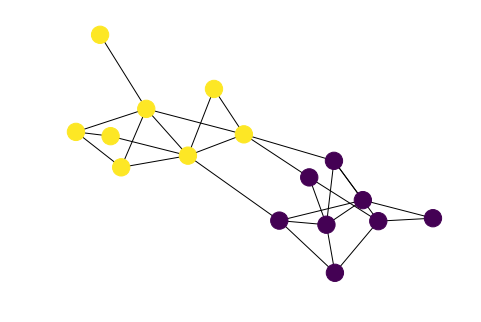

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1}
[set([0, 1, 2, 3, 4, 5, 6, 7]), set([8, 9, 10, 11, 12, 13, 14, 15])]
[set([0, 1, 2, 3, 4, 5, 6, 7]), set([8, 9, 10, 11, 12, 13, 14, 15])]
Louvain algorithm:
	Optimal number of communities: K =  4
	Best modularity: Q =  0.484762396694
	Runtime:  0.00199294090271  seconds


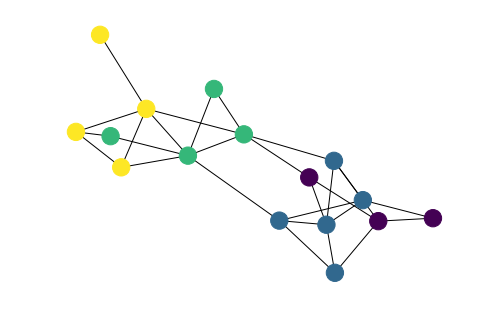

{0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 0, 8: 2, 9: 2, 10: 2, 11: 2, 12: 3, 13: 3, 14: 3, 15: 3}
[set([0, 6, 7]), set([1, 2, 3, 4, 5]), set([8, 9, 10, 11]), set([12, 13, 14, 15])]
0.515625
1.0


In [38]:
######################################################################
# Test partition conversions and Rand-index

edge_list = [[1,5],[1,7],[2,3],[2,4],[2,5],[2,9],[3,4],[3,5],[3,6],[3,8],[4,7],[5,6],[6,7],[6,10],[7,8],[8,10],[9,10],[9,11],[9,12],[9,13],[9,15],[10,11],[10,15],[12,14],[13,14],[13,15],[14,15],[15,16]]
G = edge_list_to_graph(edge_list)
G = nx.convert_node_labels_to_integers(G)
pos = nx.spring_layout(G)

t = 2
parts, coms, _, Qs = walktrap(G, t) 
Qmax_index = np.argmax(Qs)
my_best_part = partition_to_plot(coms, parts[Qmax_index])
nx.draw(G, pos, node_color= my_best_part.values())
plt.show()
print my_best_part
print partition_dict_to_sets(my_best_part)
print partition_set_to_sets(coms, parts[Qmax_index])

louvain_best_part = compare_with_Louvain(G)
nx.draw(G, pos, node_color= louvain_best_part.values())
plt.show()
print louvain_best_part
print partition_dict_to_sets(louvain_best_part)

print calculate_rand_index(partition_dict_to_sets(my_best_part), partition_dict_to_sets(louvain_best_part))
print calculate_rand_index(partition_dict_to_sets(my_best_part), partition_dict_to_sets(my_best_part))

In [48]:
######################################################################
# Comparison with Louvain algorithm: return best partition
######################################################################
import community

def compare_with_Louvain(G, add_self_edges=True, verbose=True):
#     # If needed, add self-edges
#     if add_self_edges:
#         for v in G.nodes:
#             G.add_edge(v, v)
    start_time = time.time()
    part = community.best_partition(G)
    Q = community.modularity(part, G)
    if verbose:
        print "Louvain algorithm:"
        print "\tOptimal number of communities: K = ", len(np.unique(part.values()))
        print "\tBest modularity: Q = ", Q
        print "\tRuntime: ", time.time() - start_time, " seconds"
    return part # dictionary, suitable for plotting

######################################################################
# Comparison with Markov Clustering algorithm: return best partition
######################################################################
# import markov_clustering
# external script Python3: appended at the end of this file

In [16]:
######################################################################
# Experiments on real-graphs: comparison function
######################################################################

def compare_algos(G, K_true):
    
    G = nx.convert_node_labels_to_integers(G)
    pos = nx.spring_layout(G)
    print "Ground truth: ",K_true, " communities"

    # 1.) step
    # Q vs k for various t
    plt.figure()
    for t in range(2,9)+[20,50,100]:#+[3,5,7,9,12,20,100]:
        parts, coms, _, Qs = walktrap(G, t)
        ks = np.arange(len(Qs))
        # Best number of communities
        K = len(Qs) - np.argmax(Qs)
        plt.plot(ks, Qs, label='t = ' + str(t) + ", K = " + str(K))
    plt.xlabel('iteration k')
    plt.ylabel('Modularity Q')
    plt.title('Modularity Q vs iteration')
    plt.legend()
    plt.show()
    # eta vs k for various t
    plt.figure()
    for t in range(2,9)+[20,50,100]:#+[3,5,7,9,12,20,100]:
        parts, coms, ds, _ = walktrap(G, t)
        etas = ds[1:] / ds[0:-1]
        ks = np.arange(len(etas)) + 1
        # Best number of communities
        K = 1 + len(etas) - np.argmax(etas)
        plt.plot(ks, etas, label='t = ' + str(t) + ", K = " + str(K))
    plt.xlabel('iteration k')
    plt.ylabel('$\eta$')
    plt.title('Quality $\eta$ of partition vs iteration')
    plt.legend()
    plt.show()


    # 2.) Comparison

    ################## WT
    t = 2
    start_time = time.time()
    parts, coms, _, Qs = walktrap(G, t) 
    wt_time = time.time() - start_time
    Qmax_index = np.argmax(Qs)
    print "Walktrap ( t =",str(t),") algorithm:"
    print "\tOptimal number of communities: K = ", len(Qs) - Qmax_index
    print "\tBest modularity: Q = ", Qs[Qmax_index]
    print "\tRuntime: ", wt_time, " seconds"
    my_best_part = partition_to_plot(coms, parts[Qmax_index])
    nx.draw(G, pos, node_color= my_best_part.values())
    plt.show()

    t = 5
    start_time = time.time()
    parts, coms, _, Qs = walktrap(G, t) 
    wt_time = time.time() - start_time
    Qmax_index = np.argmax(Qs)
    print "Walktrap ( t =",str(t),") algorithm:"
    print "\tOptimal number of communities: K = ", len(Qs) - Qmax_index
    print "\tBest modularity: Q = ", Qs[Qmax_index]
    print "\tRuntime: ", wt_time, " seconds"
    my_best_part = partition_to_plot(coms, parts[Qmax_index])
    nx.draw(G, pos, node_color= my_best_part.values())
    plt.show()

    t = 8
    start_time = time.time()
    parts, coms, _, Qs = walktrap(G, t) 
    wt_time = time.time() - start_time
    Qmax_index = np.argmax(Qs)
    print "Walktrap ( t =",str(t),") algorithm:"
    print "\tOptimal number of communities: K = ", len(Qs) - Qmax_index
    print "\tBest modularity: Q = ", Qs[Qmax_index]
    print "\tRuntime: ", wt_time, " seconds"
    my_best_part = partition_to_plot(coms, parts[Qmax_index])
    nx.draw(G, pos, node_color= my_best_part.values())
    plt.show()

    ################## LO
    louvain_best_part = compare_with_Louvain(G)
    nx.draw(G, pos, node_color= louvain_best_part.values())
    plt.show()

    ################## MC
    # external script

Ground truth:  2  communities


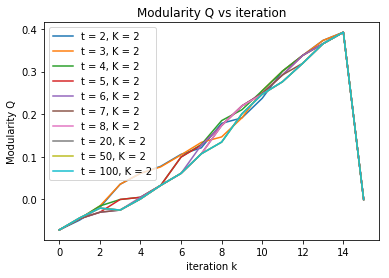

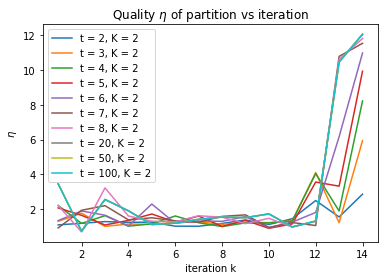

Walktrap ( t = 2 ) algorithm:
	Optimal number of communities: K =  2
	Best modularity: Q =  0.392219387755
	Runtime:  0.00383901596069  seconds


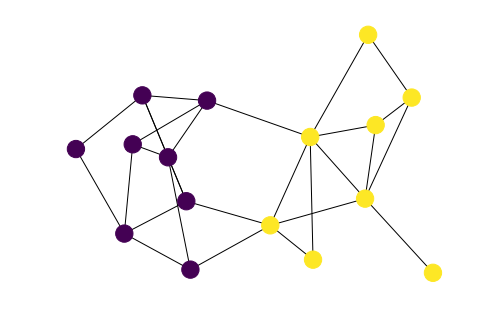

Walktrap ( t = 5 ) algorithm:
	Optimal number of communities: K =  2
	Best modularity: Q =  0.392219387755
	Runtime:  0.00395488739014  seconds


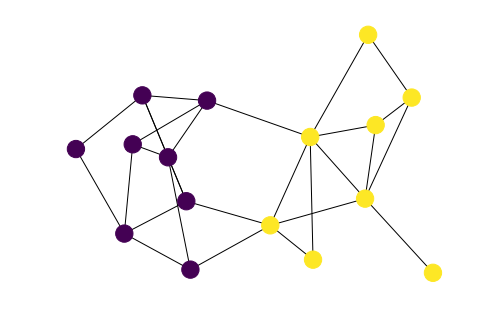

Walktrap ( t = 8 ) algorithm:
	Optimal number of communities: K =  2
	Best modularity: Q =  0.392219387755
	Runtime:  0.00382590293884  seconds


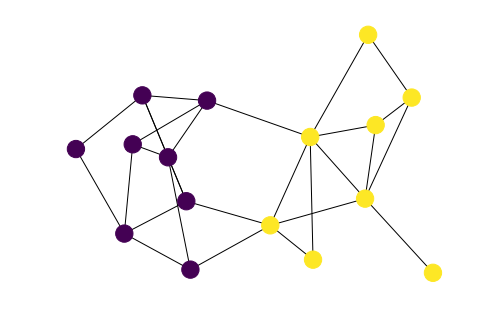

Louvain algorithm:
	Optimal number of communities: K =  4
	Best modularity: Q =  0.484762396694
	Runtime:  0.00258708000183  seconds


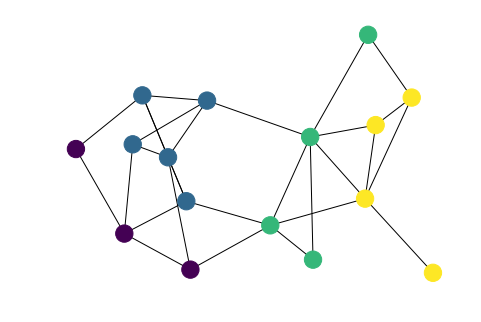

In [17]:
######################################################################
# Experiments: real graphs
######################################################################

######################################################################
# 1.) Example 16-node graph from the paper
######################################################################
edge_list = [[1,5],[1,7],[2,3],[2,4],[2,5],[2,9],[3,4],[3,5],[3,6],[3,8],[4,7],[5,6],[6,7],[6,10],[7,8],[8,10],[9,10],[9,11],[9,12],[9,13],[9,15],[10,11],[10,15],[12,14],[13,14],[13,15],[14,15],[15,16]]
G = edge_list_to_graph(edge_list)
compare_algos(G, 2)

Ground truth:  4  communities


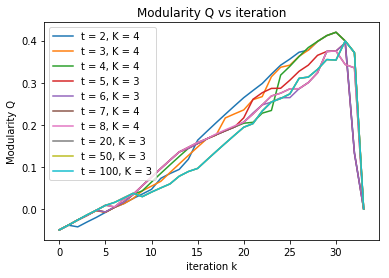

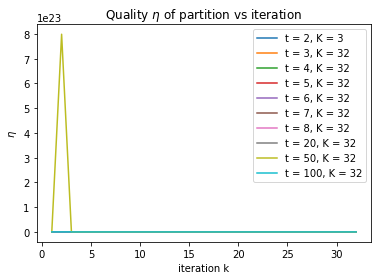

Walktrap ( t = 2 ) algorithm:
	Optimal number of communities: K =  4
	Best modularity: Q =  0.419789612097
	Runtime:  0.0133800506592  seconds


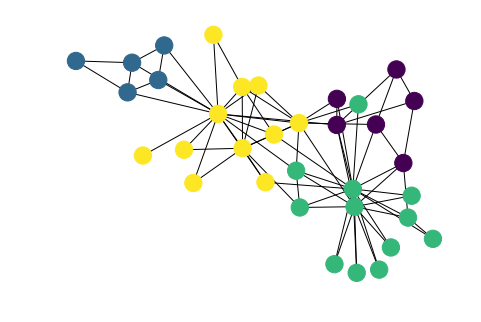

Walktrap ( t = 5 ) algorithm:
	Optimal number of communities: K =  3
	Best modularity: Q =  0.39439513478
	Runtime:  0.0126159191132  seconds


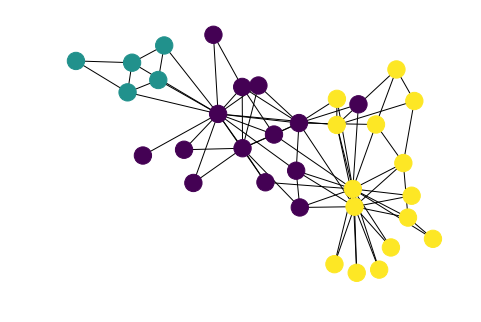

Walktrap ( t = 8 ) algorithm:
	Optimal number of communities: K =  4
	Best modularity: Q =  0.375164365549
	Runtime:  0.0123000144958  seconds


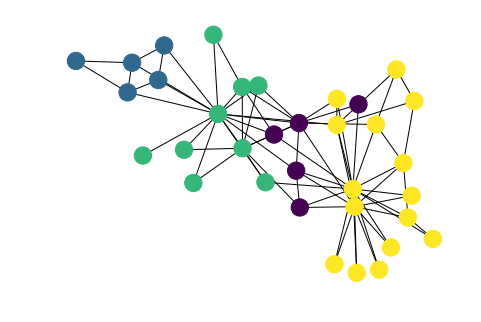

Louvain algorithm:
	Optimal number of communities: K =  4
	Best modularity: Q =  0.510682397959
	Runtime:  0.00494194030762  seconds


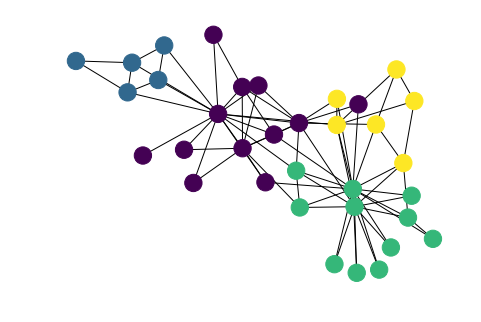

In [18]:
######################################################################
# 2.) Experiments on real-graph: Zachary’s Karate Club graph
######################################################################
G = nx.karate_club_graph()
compare_algos(G, 4)

Ground truth:  12  communities


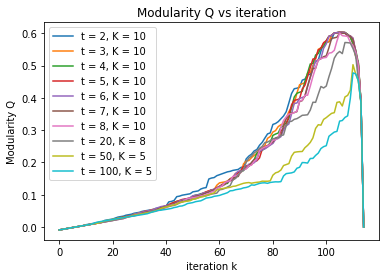

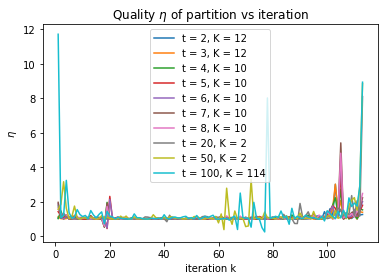

Walktrap ( t = 2 ) algorithm:
	Optimal number of communities: K =  10
	Best modularity: Q =  0.602914290428
	Runtime:  0.231062173843  seconds


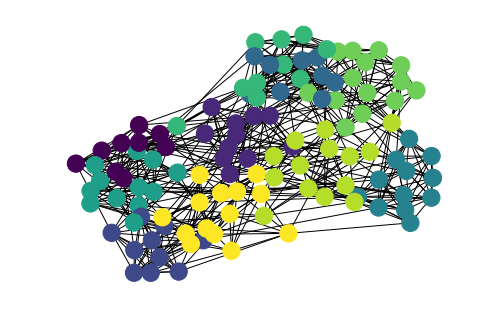

Walktrap ( t = 5 ) algorithm:
	Optimal number of communities: K =  10
	Best modularity: Q =  0.602914290428
	Runtime:  0.473833084106  seconds


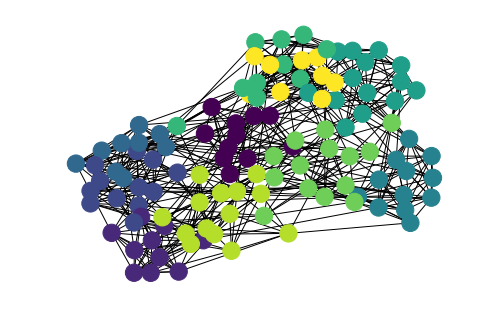

Walktrap ( t = 8 ) algorithm:
	Optimal number of communities: K =  10
	Best modularity: Q =  0.600770686246
	Runtime:  0.555921077728  seconds


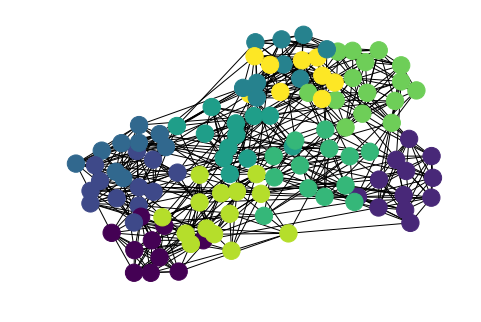

Louvain algorithm:
	Optimal number of communities: K =  11
	Best modularity: Q =  0.650682850803
	Runtime:  0.0267779827118  seconds


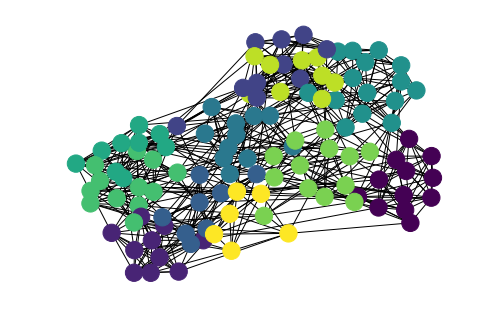

In [19]:
######################################################################
# 3.) Experiments on real-graph: The college football network
######################################################################
G = nx.read_gml('./../Datasets/football/football.gml')
compare_algos(G, 12)

Ground truth:  6  communities


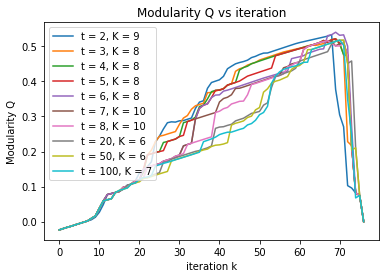

/home/janciovec/.local/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in divide
/home/janciovec/.local/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in divide


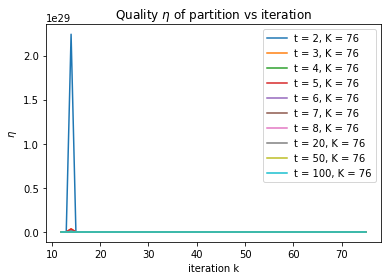

Walktrap ( t = 2 ) algorithm:
	Optimal number of communities: K =  9
	Best modularity: Q =  0.53286006572
	Runtime:  0.135764122009  seconds


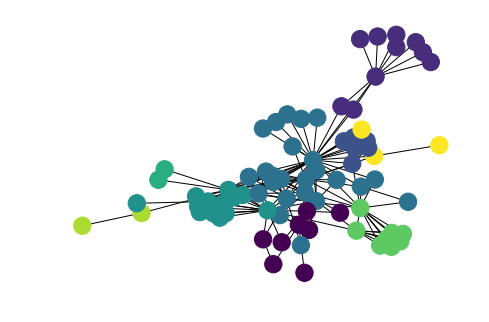

Walktrap ( t = 5 ) algorithm:
	Optimal number of communities: K =  8
	Best modularity: Q =  0.521405542811
	Runtime:  0.0997340679169  seconds


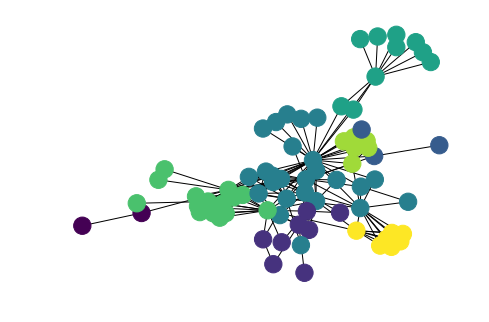

Walktrap ( t = 8 ) algorithm:
	Optimal number of communities: K =  10
	Best modularity: Q =  0.516174282349
	Runtime:  0.128497838974  seconds


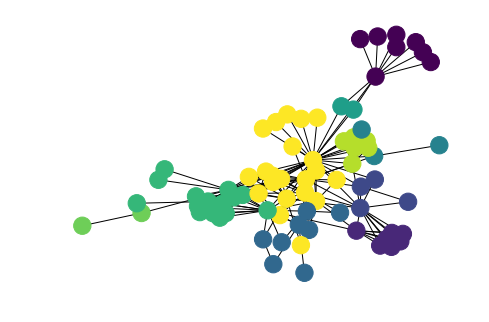

Louvain algorithm:
	Optimal number of communities: K =  9
	Best modularity: Q =  0.623912706164
	Runtime:  0.0102519989014  seconds


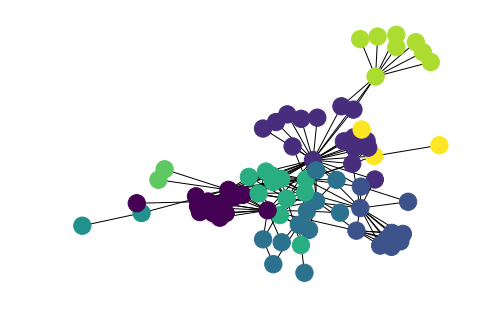

In [20]:
######################################################################
# 4.) Experiments on real-graph: Les Miserables network
######################################################################
G = nx.read_gml('./../Datasets/lesmis/lesmis.gml')
compare_algos(G, 6)

Ground truth:  2  communities


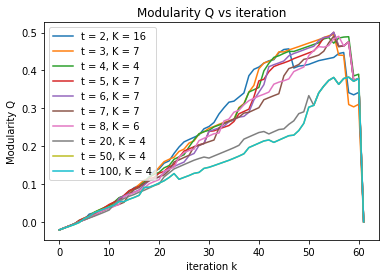

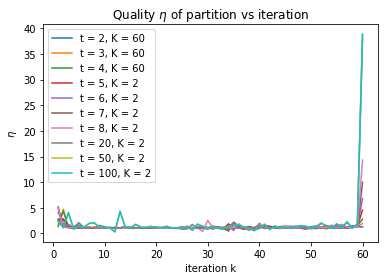

Walktrap ( t = 2 ) algorithm:
	Optimal number of communities: K =  16
	Best modularity: Q =  0.456746173015
	Runtime:  0.0406851768494  seconds


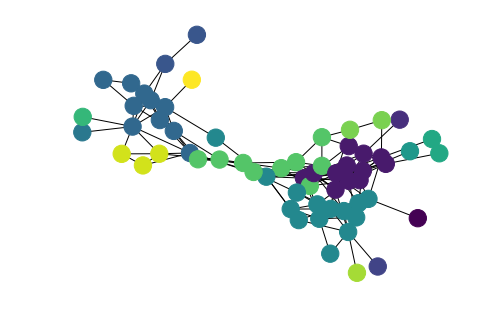

Walktrap ( t = 5 ) algorithm:
	Optimal number of communities: K =  7
	Best modularity: Q =  0.500692219453
	Runtime:  0.0364229679108  seconds


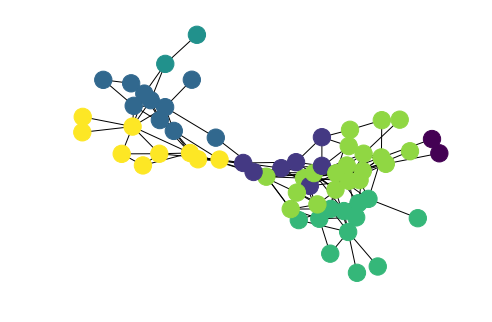

Walktrap ( t = 8 ) algorithm:
	Optimal number of communities: K =  6
	Best modularity: Q =  0.490032039872
	Runtime:  0.0376839637756  seconds


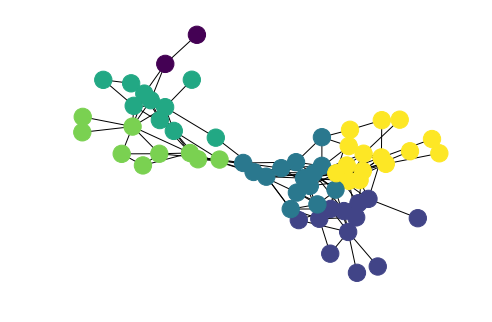

Louvain algorithm:
	Optimal number of communities: K =  7
	Best modularity: Q =  0.602055649966
	Runtime:  0.0108811855316  seconds


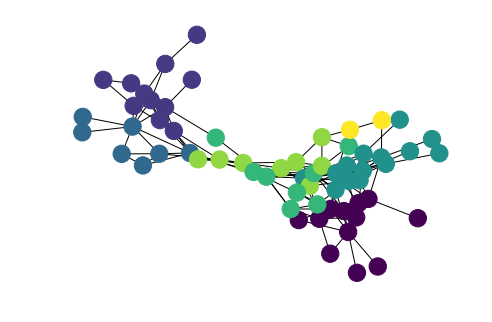

In [22]:
######################################################################
# 5.) Experiments on real-graph: Dolphins network
######################################################################
G = nx.read_gml('./../Datasets/dolphins/dolphins.gml')
compare_algos(G, 2)

In [59]:
########################################################################################
# Experiments on random graphs: random partition graph: homogenous/heterogenous
########################################################################################
# A partition graph is a graph of communities with sizes defined by s in sizes. 
# Nodes in the same group are connected with probability p_in 
# and nodes of different groups are connected with probability p_out.

n_range = [1000.]
# n_range = [30., 100., 200., 300., 500.]
n_range = [30., 100., 200., 300., 500., 700., 1000.]
ts = [2, 5, 8]
heterogeneous = True

p_in_range = [0.5, 0.4]
p_out_range = [0.1, 0.2]
gamma_range = [0.5, 0.4, 0.3]
num_runs = len(p_in_range) * len(p_out_range) * len(gamma_range)

algos = ['WT2', 'WT5', 'WT8', 'LO']
# R = {'WT2': [], 'WT5': [], 'WT8': [], 'LO': [], 'MC': []}
# tr = {'WT2': [], 'WT5': [], 'WT8': [], 'LO': [], 'MC': []}
# acc = {'WT2': [], 'WT5': [], 'WT8': [], 'LO': [], 'MC': []}

for n in n_range:

    K_range = [int(np.ceil(n ** gamma)) for gamma in gamma_range] # number of communities K = n^gamma

    R_current = {'WT2': 0., 'WT5': 0., 'WT8': 0., 'LO': 0., 'MC': 0.}
    tr_current = {'WT2': 0., 'WT5': 0., 'WT8': 0., 'LO': 0., 'MC': 0.}
    acc_current = {'WT2': 0., 'WT5': 0., 'WT8': 0., 'LO': 0., 'MC': 0.}

    for K_true in K_range:
        
        if heterogeneous:
            sizes = np.random.uniform(0.,1.,K_true)
            sizes = (n * sizes / np.sum(sizes)).astype(int)
        else:
            sizes = np.repeat([int(np.ceil(n / K_true))], K_true)
            
        for p_in in p_in_range:
            for p_out in p_out_range:
                
                # Generate graph
                while True:
                    G = nx.random_partition_graph(sizes, p_in, p_out)
                    if nx.is_connected(G): # Ensure the graph is connected
                        break
                true_part = G.graph['partition']

                # Run all algos
                for t in ts:
                    start_time = time.time()
                    parts, coms, _, Qs = walktrap(G, t) 
                    tr_current['WT'+str(t)] += time.time() - start_time
                    Qmax_index = np.argmax(Qs)
                    K_pred = len(Qs) - Qmax_index
                    if K_pred == K_true:
                        acc_current['WT'+str(t)] += 1.
                    R_current['WT'+str(t)] += calculate_rand_index(true_part, partition_set_to_sets(coms, parts[Qmax_index]))

                louvain_best_part = partition_dict_to_sets(compare_with_Louvain(G, verbose=False))
                if len(louvain_best_part) == K_true:
                    acc_current['LO'] += 1.
                R_current['LO'] += calculate_rand_index(true_part, louvain_best_part)
                               
    # Average Rand-index R' over all num_runs runs
    for algo in algos:
        R[algo].append(R_current[algo] / num_runs)
        tr[algo].append(tr_current[algo] / num_runs)
        acc[algo].append(acc_current[algo] / num_runs)

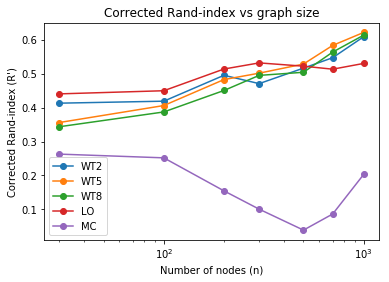

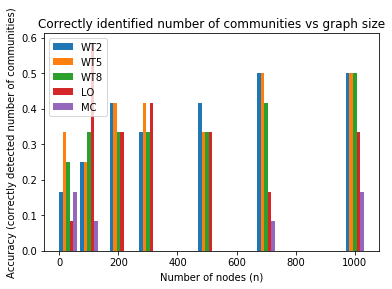

In [75]:
# Plot the results R'(n) and acc(n) for the 5 algorithms

n_range = [30., 100., 200., 300., 500., 700., 1000.]
algos = ['WT2', 'WT5', 'WT8', 'LO', 'MC']
mc_data = np.load('MC_random.npz')
# R['MC'] = mc_data['R'][:-2]
# tr['MC'] = mc_data['tr'][:-2]
# acc['MC'] = mc_data['acc'][:-2]
R['MC'] = mc_data['R']
tr['MC'] = mc_data['tr']
acc['MC'] = mc_data['acc']

plt.figure()
for algo in algos:
    plt.plot(n_range, R[algo], 'o-', label=algo)
plt.xlabel('Number of nodes (n)')
plt.ylabel("Corrected Rand-index (R')")
plt.title('Corrected Rand-index vs graph size')
plt.xscale('log')
plt.legend()
plt.show()

plt.figure()
for i, algo in enumerate(algos):
    plt.bar(np.array(n_range) - 24. + i*12., acc[algo], width=12., align='center', label=algo)
#     plt.xscale('log')
plt.xlabel('Number of nodes (n)')
plt.ylabel("Accuracy (correctly detected number of communities)")
plt.title('Correctly identified number of communities vs graph size')
plt.legend(loc='best')
plt.show()

# plt.figure()
# for algo in algos:
#     plt.plot(n_range, R[algo], 'o-', label=algo)
# plt.xlabel('Number of nodes (n)')
# plt.ylabel("Corrected Rand-index (R')")
# plt.title('Corrected Rand-index vs graph size')
# # plt.xscale('log')
# plt.legend()
# plt.show()

# plt.figure()
# for algo in algos:
#     plt.plot(n_range, tr[algo], 'o-', label=algo)
# plt.xlabel('Number of nodes (n)')
# plt.ylabel("Running time")
# plt.title('Running time vs graph size')
# plt.xscale('log')
# plt.yscale('log')
# plt.legend()
# plt.show()



In [ ]:
import numpy as np
import networkx as nx
import markov_clustering as mc
import random
import time

######################################################################
# Comparison with Markov Clustering algorithm: return best partition
######################################################################

def compare_with_MC(G, K_true):
	G = nx.convert_node_labels_to_integers(G)
	print ("Ground truth: ",K_true, " communities")
	start_time = time.time()
	matrix = nx.to_scipy_sparse_matrix(G)
	result = mc.run_mcl(matrix)           # run MCL with default parameters
	clusters = mc.get_clusters(result)    # get clusters
	mc_time = time.time() - start_time
	
	Q = 0. # modularity
	G_total_weight = G.number_of_edges()
	part = {}
	for i, c in enumerate(clusters):
		internal_weight = 0.
		total_weight = 0.
		for v in c:
			part[v] = i
			for w, _ in G.adj[v].items():
				if w in c:
					internal_weight += 1.	# internal edge
				else:
					total_weight += 0.5		# external edge

		internal_weight = internal_weight / 2 # because each edge was counted twice
		total_weight += internal_weight
		Q += ( internal_weight - (total_weight*total_weight/G_total_weight) ) / G_total_weight

	print ("\tOptimal number of communities: K = ", len(np.unique(list(part.values()))))
	print ("\tRuntime: ", mc_time, " seconds")
	print ("\tModularity: ", Q)
	return part # partition as dictionary, suitable for plotting

######################################################################
# Calculate Rand index for partitions P1 and P2, given lists of sets
######################################################################
def calculate_rand_index(P1, P2):
    N = 0
    sum_intersect = 0.
    sum_C1 = 0.
    sum_C2 = np.sum([len(s)**2 for s in P2])
    for s1 in P1:
        N += len(s1)
        sum_C1 += len(s1)**2
        for s2 in P2:
            sum_intersect += len(s1.intersection(s2))**2
    return (N*N*sum_intersect - sum_C1*sum_C2) / ( 0.5*N*N*(sum_C1 + sum_C2) - sum_C1*sum_C2)

######################################################################
# Convert edge list to Networkx Graph
######################################################################
def edge_list_to_graph(edges, verbose=False):
    G = nx.Graph()
    G.add_edges_from(edges)
    if verbose:
        print (G.number_of_edges(), " edges, ", G.number_of_nodes(), " nodes")
    return G

print ("Markov Clustering algorithm:")

def eval_MC_on_real():
	edge_list = [[1,5],[1,7],[2,3],[2,4],[2,5],[2,9],[3,4],[3,5],[3,6],[3,8],[4,7],[5,6],[6,7],[6,10],[7,8],[8,10],[9,10],[9,11],[9,12],[9,13],[9,15],[10,11],[10,15],[12,14],[13,14],[13,15],[14,15],[15,16]]
	G = edge_list_to_graph(edge_list)
	compare_with_MC(G, 2)
	print()
	G = nx.karate_club_graph()
	compare_with_MC(G, 4)
	print()

	G = nx.read_gml('./../Datasets/football/football.gml')
	compare_with_MC(G, 12)
	print()

	G = nx.read_gml('./../Datasets/lesmis/lesmis.gml')
	compare_with_MC(G, 6)
	print()

	G = nx.read_gml('./../Datasets/dolphins/dolphins.gml')
	compare_with_MC(G, 2)
	print()

def eval_MC_on_random(heterogeneous=False):

	n_range = [30., 100., 200., 300., 500., 700., 1000.]

	p_in_range = [0.5, 0.4]
	p_out_range = [0.1, 0.2]
	gamma_range = [0.5, 0.4, 0.3]	
	# p_in_range = [0.5, 0.4, 0.3]
	# p_out_range = [0.1]
	# gamma_range = [0.5, 0.4, 0.3]
	num_runs = len(p_in_range) * len(p_out_range) * len(gamma_range)

	R = []
	tr = []
	acc = []

	for n in n_range:

		K_range = [int(np.ceil(n ** gamma)) for gamma in gamma_range] # number of communities K = n^gamma


		R_current = 0.
		tr_current = 0.
		acc_current = 0.

		for K_true in K_range:

			if heterogeneous:
				sizes = np.random.uniform(0.,1.,K_true)
				sizes = (n * sizes / np.sum(sizes)).astype(int)
			else:
				sizes = np.repeat([int(np.ceil(n / K_true))], K_true)

			for p_in in p_in_range:
				for p_out in p_out_range:

					# Generate graph
					while True:
						G = nx.random_partition_graph(sizes, p_in, p_out)
						if nx.is_connected(G): # Ensure the graph is connected
							break
					true_part = G.graph['partition']


					start_time = time.time()
					result = mc.run_mcl(nx.to_scipy_sparse_matrix(G))       # run MCL with default parameters
					clusters = mc.get_clusters(result)    # get clusters
					tr_current += time.time() - start_time
					K_pred = len(clusters)
					if K_pred == K_true:
						acc_current += 1.


					list_of_sets = []
					for c in clusters:
						list_of_sets.append(set(c))

					R_current += calculate_rand_index(true_part, list_of_sets)

		# Average Rand-index R' over all num_runs runs
		R.append(R_current / num_runs)
		tr.append(tr_current / num_runs)
		acc.append(acc_current / num_runs)

	np.savez('MC_random_hetero.npz', R=R, tr=tr, acc=acc)

eval_MC_on_random(True)

#eval_MC_on_real()